In [53]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import gmaps
import numpy as np
#list api keys here
from config import (api_key, gkey, sd_api_key, app_id)

state = 'Oklahoma'
state_code = 40
state_abbr = 'OK'

In [2]:
url = 'http://api.census.gov/data/2010/sf1?get=P0010001,NAME&for=county:*&in=state:40&key=' + api_key
response = requests.get(url).json()
county_name = []
county_code = []
census_variable_code = []
counter = 0;
for county in response:
    if (counter > 0):
        county_name.append(county[1])
        county_code.append(county[3])
        census_variable_code.append(county[0])
    counter = counter + 1
    
all_counties = {"County" : county_name,
               "County Code" : county_code,
               "Census Code" : census_variable_code}

all_counties_df = pd.DataFrame(all_counties)
all_counties_df.head()

,County,County Code,Census Code
0,Adair County,001,22683
1,Alfalfa County,003,5642
2,Atoka County,005,14182
3,Beaver County,007,5636
4,Beckham County,009,22119


In [3]:
url = 'http://api.census.gov/data/2010/sf1?get=P0010001,P0040003&for=zip+code+tabulation+area:*&in=state:40'
response = requests.get(url).json()
#print (response)
census_variable_p0010001 = []
census_variable_p0040003 = []
zip_code = []
counter = 0
for data in response:
    if (counter > 0):
        census_variable_p0010001.append(data[0])
        census_variable_p0040003.append(data[1])
        zip_code.append(data[3])
    counter = counter + 1

zip_codes_for_state = {"Census Code" : census_variable_p0010001,
                      "Census Code (P0040003)" : census_variable_p0040003,
                      "Zip Code" : zip_code}
zip_codes_for_state_df = pd.DataFrame(zip_codes_for_state)
zip_codes_for_state_df.head()

,Census Code,Census Code (P0040003),Zip Code
0,146,64,67950
1,1062,45,73002
2,20617,1417,73003
3,857,29,73004
4,9541,1013,73005


In [4]:
file_one = "./Resources/UnemploymentReport.csv"

income_df = pd.read_csv(file_one)
house_income = income_df[["Name", "Median Household Income (2016)"]]
house_income = house_income.dropna(how='any')


In [5]:
cities = house_income["Name"]
g_lat = []
g_lon= []
g_name = []

for city in cities:
    target_url = ('https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}').format(city, gkey)
    geo_data = requests.get(target_url).json()
    g_name.append(city)
    g_lat.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    g_lon.append(geo_data["results"][0]["geometry"]["location"]["lng"])

In [6]:
g_dict = {"Name": g_name,
          "g_lat": g_lat,
          "g_lon": g_lon}

g_df = pd.DataFrame(g_dict)

In [7]:
final_table = pd.merge(house_income, g_df, on="Name", how="left")
final_table

final_table.to_csv("./Resources/final_household_income.csv", index=False, header = True)

In [8]:
gmaps.configure(api_key=gkey)

In [9]:
locations = final_table[["g_lat", "g_lon"]].astype(float)

household_income = final_table["Median Household Income (2016)"].astype(float)

In [10]:
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=household_income, 
                                 dissipating=False, max_intensity=100000,
                                 point_radius = 1)


heat_layer.dissipating = False
heat_layer.max_intensity = 100000
heat_layer.point_radius = .5

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [11]:
crime_data = pd.read_csv('./Resources/crime-report.csv', encoding="utf-8")
crime_data_ok = crime_data[crime_data['state_abbr'] == 'OK']
crime_data_processed = pd.DataFrame()
crime_data_processed['Agency Name'] = crime_data_ok['agency_name']
crime_data_processed['County'] = crime_data_ok['primary_county']
crime_data_processed['FIPS'] = crime_data_ok['primary_county_fips']
clean_df = crime_data_processed.dropna()
grouped_county_crime = clean_df.groupby(['County'])
#print(grouped_county_crime.count())

In [12]:
highschool_dropout_data = pd.read_csv('./Resources/EducationReport-hd.csv', encoding="utf-8")
hs_data_processed = pd.DataFrame()
#highschool_dropout_data.head()
hs_data_processed['County'] = highschool_dropout_data['Unnamed: 1']
hs_data_processed['FIPS'] = highschool_dropout_data['Unnamed: 0']
hs_data_processed['Dropout Percentage'] = highschool_dropout_data['Unnamed: 8']

clean_hs_df = hs_data_processed.dropna()
temp_df = clean_hs_df[clean_hs_df['County'] != 'Name']
temp_df2 = temp_df[temp_df['County'] != 'Oklahoma']

county_name = []
for grade in temp_df2['County']:
    county_nm = grade.split(",")[0]
    county = county_nm.split(" ")[0]
    county_name.append(county)
    

temp_df2['County'] = county_name
temp_df2['Dropout Percentage'] = temp_df2['Dropout Percentage'].str.replace('%', '')
temp_df2.head()
#print(temp_df2)

/anaconda3/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,County,FIPS,Dropout Percentage
3,Adair,40001,20.5
4,Alfalfa,40003,11.5
5,Atoka,40005,18.2
6,Beaver,40007,15.8
7,Beckham,40009,15.5


In [13]:
school_name = []
rating = []
low_grade = []
high_grade = []
school_level = []
county = []
district = []
year = []
#for loop that will go through school per page and add info to dictionary
for x in range(1,10):
    count = 50 #every new page the counter equals 1
    #calls the URL and gets json file
    request_url =  f"https://api.schooldigger.com/v1.1/rankings/schools/{state_abbr}?page={x}&perPage={count}&appID={app_id}&appKey={sd_api_key}"
    response = requests.get(request_url).json()
    #print(response)
    schools = response['schoolList']
    for school in schools:
        name = school['schoolName']
        school_name.append(name)
        try:
            rating.append(school['rankHistory'][0]['rank'])
            low_grade.append(school['lowGrade'])
            high_grade.append(school['highGrade'])
            school_level.append(school['schoolLevel'])
            county.append(school['county']['countyName'])
            district.append(school['district']['districtName'])
            print(f"Processed | {name}")
        except TypeError:
            print(f"Not Processed | {name}")
            
        x = x + 1 #page increases

#dictionary that will hold all data
school_dict = {"School Name": school_name,
              "Ratings": rating,
              "Low Grade": low_grade,
              "High Grade": high_grade,
              "Level": school_level,
              "County": county,
              "District": district}

#makes dictionary into DataFrame
school_df = pd.DataFrame(school_dict)
school_df.head()

Processed | Centennial Elementary School
Processed | Grove Valley Elementary School
Processed | Chisholm Elementary School
Processed | Westwood Elementary School
Processed | Cleveland Elementary School
Processed | North Intermediate School
Processed | Frontier Elementary School
Processed | Sadler Arts Academy
Processed | Prairie Vale Elementary School
Processed | Pamela Hodson Elementary School
Processed | Lakeview Elementary School
Processed | South Lake Elementary School
Processed | McKinley Elementary School
Processed | Spring Creek Elementary School
Processed | Plainview Intermediate Elementary School
Processed | McCord Public School
Processed | Heritage Elementary
Processed | Southeast Elementary School
Processed | Oakridge Elementary School
Processed | Henry Zarrow International School
Processed | Sangre Ridge Elementary School
Processed | Wilson Elementary School
Processed | Chisholm Elementary School
Processed | West Field Elementary School
Processed | Prague Elementary School


Processed | Valliant Elementary School
Processed | Collinsville Upper Elementary School
Processed | Arapaho-Butler Elementary School
Processed | Frederick Elementary School
Processed | Union Elementary School
Processed | Little Axe Elementary School
Processed | Central Elementary School
Processed | Rhoades Elementary School
Processed | Anderson Public School
Processed | Crescent Elementary School
Processed | Emerson Elementary School
Processed | Tulakes Elementary School
Processed | Apollo Elementary School
Processed | Ketchum Elementary School
Processed | Greenwood Elementary School
Processed | Mustang Trails Elementary School
Processed | Northwoods Fine Arts Academy
Processed | Mustang Creek Elementary School
Processed | Patrick Henry Elementary School
Processed | Davis Elementary School
Processed | Thomas Ies
Processed | Brantly Elementary School
Processed | Northridge Elementary School
Processed | Silo Elementary School
Processed | Lee Elementary School
Processed | Chouteau Element

,School Name,Ratings,Low Grade,High Grade,Level,County,District
0,Centennial Elementary School,1,PK,5,Elementary,Oklahoma,Edmond
1,Grove Valley Elementary School,2,PK,4,Elementary,Oklahoma,Deer Creek
2,Chisholm Elementary School,3,PK,5,Elementary,Oklahoma,Edmond
3,Westwood Elementary School,4,PK,5,Elementary,Payne,Stillwater
4,Cleveland Elementary School,5,PK,5,Elementary,Cleveland,Norman


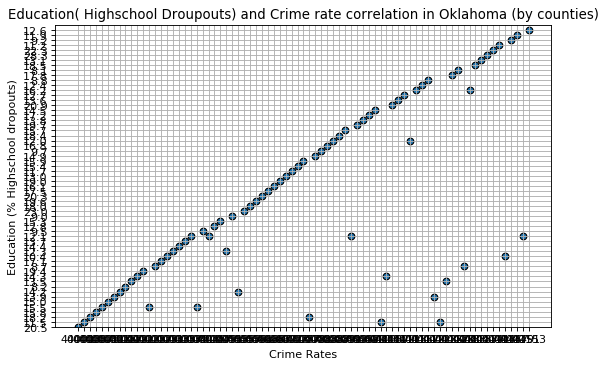

In [49]:
#Education VS Crime

plt.figure(num=None, figsize=(8,5), dpi=80)
plt.scatter(temp_df2["FIPS"],temp_df2["Dropout Percentage"],marker="o",edgecolors="black")
plt.title("Education( Highschool Droupouts) and Crime rate correlation in Oklahoma (by counties)")
plt.ylabel("Education (% Highschool dropouts)")
plt.ylim(0, 60)
plt.xlabel("Crime Rates")
#plt.xlim(, 100)

plt.grid(True)
plt.savefig("EducationVsCrimeRate.png")
plt.show()

In [15]:
house_income= "./Resources/final_household_income.csv"
house_income = pd.read_csv(house_income)
house_income.head()

county_name = []
for entry in house_income['Name']:
    county_nm = entry.split(",")[0]
    county = county_nm.split(" ")[0]
    county_name.append(county)

house_income['County'] = county_name    
house_income.head()

,Name,Median Household Income (2016),g_lat,g_lon,County
0,"Adair County, OK",33632.0,35.912731,-94.645035,Adair
1,"Alfalfa County, OK",53695.0,36.743592,-98.396494,Alfalfa
2,"Atoka County, OK",36766.0,34.450990,-95.983258,Atoka
3,"Beaver County, OK",53493.0,36.744019,-100.529612,Beaver
4,"Beckham County, OK",47407.0,35.268727,-99.634135,Beckham


In [16]:
inc_crime = pd.merge(house_income, crime_data_processed, how ="left", on="County")

grouped_inc= inc_crime.groupby(['County'])
print(grouped_inc.count())

              Name  Median Household Income (2016)  g_lat  g_lon  Agency Name  \
County                                                                          
Adair            4                               4      4      4            4   
Alfalfa          4                               4      4      4            4   
Atoka            5                               5      5      5            5   
Beaver           2                               2      2      2            2   
Beckham          4                               4      4      4            4   
Blaine           6                               6      6      6            6   
Bryan            9                               9      9      9            9   
Caddo            7                               7      7      7            7   
Canadian         7                               7      7      7            7   
Carter           5                               5      5      5            5   
Cherokee         4          

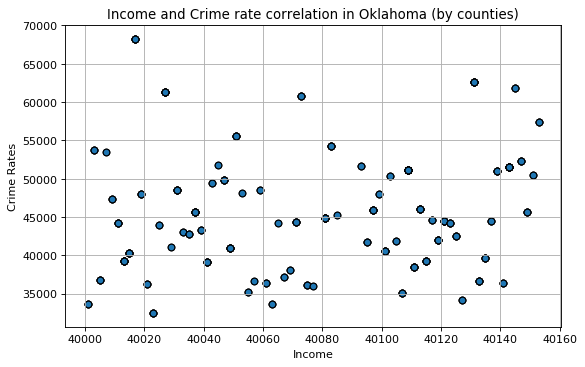

In [17]:
#Income VS Crime
plt.figure(num=None, figsize=(8,5), dpi=80)
plt.scatter(inc_crime["FIPS"],inc_crime["Median Household Income (2016)"],marker="o",edgecolors="black")
plt.title("Income and Crime rate correlation in Oklahoma (by counties)")
plt.ylabel("Crime Rates")
#plt.ylim(-100, 150)
plt.xlabel("Income")
#plt.xlim(-80, 100)

plt.grid(True)
plt.savefig("IncomeVsCrimeRate.png")
#final_table["house income"]
plt.show()

In [25]:
inc_edu = pd.merge(house_income, school_df, how ="left", on="County")

edu_inc_clean= inc_edu.dropna()
grouped_inc_edu= edu_inc_clean.groupby(['County'])
grouped_inc_edu.head()
#print(grouped_inc_edu.count())

,Name,Median Household Income (2016),g_lat,g_lon,County,School Name,Ratings,Low Grade,High Grade,Level,District
0,"Adair County, OK",33632.0,35.912731,-94.645035,Adair,Zion Public School,175.0,PK,8,Elementary,Zion
1,"Adair County, OK",33632.0,35.912731,-94.645035,Adair,Maryetta Public School,376.0,PK,8,Elementary,Maryetta
2,"Adair County, OK",33632.0,35.912731,-94.645035,Adair,Westville Elementary School,392.0,PK,6,Elementary,Westville
4,"Atoka County, OK",36766.0,34.450990,-95.983258,Atoka,Atoka Elementary School,334.0,PK,8,Elementary,Atoka
6,"Beckham County, OK",47407.0,35.268727,-99.634135,Beckham,Merritt Elementary School,125.0,PK,8,Elementary,Merritt
7,"Beckham County, OK",47407.0,35.268727,-99.634135,Beckham,Sayre Elementary School,335.0,PK,5,Elementary,Sayre
8,"Beckham County, OK",47407.0,35.268727,-99.634135,Beckham,Fairview Elementary School,366.0,3,4,Elementary,Elk City
9,"Blaine County, OK",44229.0,35.882549,-98.396494,Blaine,Watonga Elementary School,212.0,PK,5,Elementary,Watonga
10,"Bryan County, OK",39219.0,33.902127,-96.322607,Bryan,Ward Elementary School East,157.0,4,6,Elementary,Colbert
11,"Bryan County, OK",39219.0,33.902127,-96.322607,Bryan,Silo Elementary School,274.0,PK,5,Elementary,Silo


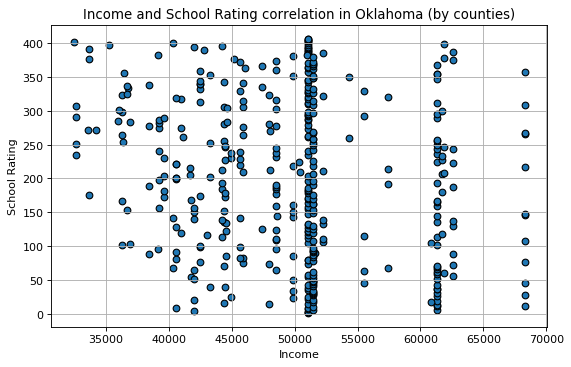

In [28]:
#Income VS Education
plt.figure(num=None, figsize=(8,5), dpi=80)
plt.scatter(edu_inc_clean["Median Household Income (2016)"],edu_inc_clean["Ratings"],marker="o",edgecolors="black")
plt.title("Income and School Rating correlation in Oklahoma (by counties)")
plt.ylabel("School Rating")
#plt.ylim(-100, 150)
plt.xlabel("Income")
#plt.xlim(-80, 100)

plt.grid(True)
plt.savefig("IncomeVsSchoolRating.png")

plt.show()

In [29]:
#Crime and School Ratings
crime_edu = pd.merge(crime_data_processed, school_df, how ="left", on="County")

crime_edu_clean= crime_edu.dropna()

grouped_crime_edu= crime_edu_clean.groupby(['County'])
grouped_crime_edu.head()

,Agency Name,County,FIPS,School Name,Ratings,Low Grade,High Grade,Level,District
1,Achille Police Department,Bryan,40013.0,Ward Elementary School East,157.0,4,6,Elementary,Colbert
2,Achille Police Department,Bryan,40013.0,Silo Elementary School,274.0,PK,5,Elementary,Silo
3,Achille Police Department,Bryan,40013.0,Durant Intermediate Elementary School,282.0,4,6,Elementary,Durant
4,Adair County Sheriff's Office,Adair,40001.0,Zion Public School,175.0,PK,8,Elementary,Zion
5,Adair County Sheriff's Office,Adair,40001.0,Maryetta Public School,376.0,PK,8,Elementary,Maryetta
6,Adair County Sheriff's Office,Adair,40001.0,Westville Elementary School,392.0,PK,6,Elementary,Westville
7,Ada Police Department,Pontotoc,40123.0,Homer Elementary School,113.0,PK,5,Elementary,Byng
8,Ada Police Department,Pontotoc,40123.0,Latta Elementary School,139.0,PK,5,Elementary,Latta
9,Ada Police Department,Pontotoc,40123.0,Byng Elementary School,193.0,4,6,Elementary,Byng
10,Ada Police Department,Pontotoc,40123.0,Washington Elementary School,396.0,3,4,Elementary,Ada


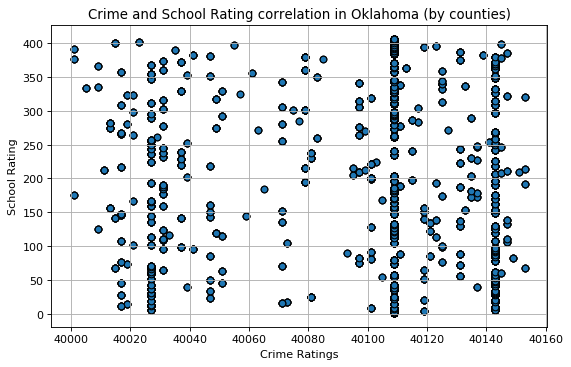

In [32]:
plt.figure(num=None, figsize=(8,5), dpi=80)
plt.scatter(crime_edu_clean["FIPS"],crime_edu_clean["Ratings"],marker="o",edgecolors="black")
plt.title("Crime and School Rating correlation in Oklahoma (by counties)")
plt.ylabel("School Rating")
#plt.ylim(-100, 150)
plt.xlabel("Crime Ratings")
#plt.xlim(-80, 100)

plt.grid(True)
plt.savefig("CrimeVsSchoolRating.png")

plt.show()

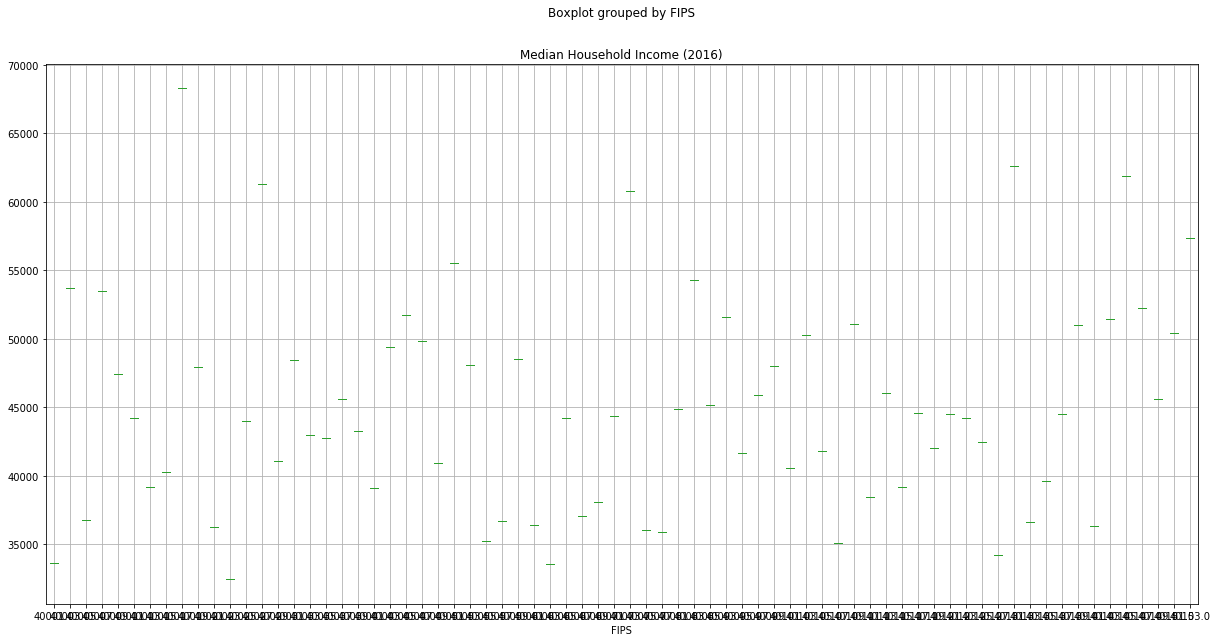

In [35]:
#boxplot - final hypothesis- Crime impacts Income
inc_crime.boxplot("Median Household Income (2016)", by="FIPS", figsize=(20, 10))
#df.boxplot("FIPS", by="Median Household Income (2016)", figsize=(20, 10))

In [58]:
sample_edu_inc = edu_inc_clean.iloc[np.random.choice(np.arange(len(edu_inc_clean)), 10, False)]
sample_edu_inc.head()

#sample_edu_inc.boxplot("Median Household Income (2016)", by="Ratings", figsize=(20, 10))

,Name,Median Household Income (2016),g_lat,g_lon,County,School Name,Ratings,Low Grade,High Grade,Level,District
158,"McClain County, OK",61730.0,35.028232,-97.481416,McClain,Blanchard Intermediate Elementary School,180.0,3,5,Elementary,Blanchard
288,"Payne County, OK",42035.0,36.144999,-97.006839,Payne,Highland Park Elementary School,150.0,PK,5,Elementary,Stillwater
267,"Oklahoma County, OK",51082.0,35.603832,-97.351656,Oklahoma,Windsor Hills Elementary School,400.0,PK,5,Elementary,Putnam City
206,"Oklahoma County, OK",51082.0,35.603832,-97.351656,Oklahoma,Oakdale Public School,42.0,PK,8,Elementary,Oakdale
76,"Comanche County, OK",48493.0,34.661278,-98.396494,Comanche,Flower Mound Public School,65.0,PK,5,Elementary,Flower Mound
